In [1]:
# regional analysis

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import function_modis
from importlib import reload
reload(function_modis)
from function_modis import plot_metrics

import sys
sys.path.append("../")


In [2]:
# regional set up
path_fig = '/home/sc3020/OneDrive/Paper/Paper4/Nature/submittion2/Figures2_iAOD/'

regions_with_bounds = {
    'n.hem': {'latitude': (20, 90), 'longitude': (-180, 179.99)},
    'tropics': {'latitude': (-20, 20), 'longitude': (-180, 179.99)},
    's.hem': {'latitude': (-90, -20), 'longitude': (-180, 179.99)},
    'n.pac': {'latitude': (25, 60), 'longitude': (145, -130)},
    'n.amer': {'latitude': (25, 60), 'longitude': (-120, -75)},
    'n.atl': {'latitude': (25, 65), 'longitude': (-70, -10)},
    'europe': {'latitude': (35, 75), 'longitude': (-13, 42)},
    'n.africa': {'latitude': (5, 35), 'longitude': (-12.5, 37)},
    'w.asia': {'latitude': (15, 60), 'longitude': (42, 103)},
    'e.asia': {'latitude': (25, 60), 'longitude': (103, 150)},
    'm.pac': {'latitude': (-20, 20), 'longitude': (170, -105)},
    's.amer': {'latitude': (-40, 5), 'longitude': (-75, -45)},
    's.atl': {'latitude': (-60, 0), 'longitude': (-30, 10)},
    's.africa': {'latitude': (-30, 5), 'longitude': (13, 37)},
    'indian': {'latitude': (-50, 5), 'longitude': (55, 90)},
    'se.asia': {'latitude': (-15, 25), 'longitude': (90, 125)},
    's.pac': {'latitude': (-60, -25), 'longitude': (-170, -80)},
    'austnz': {'latitude': (-45, -15), 'longitude': (120, 175)},
    'artic': {'latitude': (60, 90), 'longitude': (-180, 179.99)},
    'antarctic': {'latitude': (-90, -60), 'longitude': (-180, 179.99)}
}

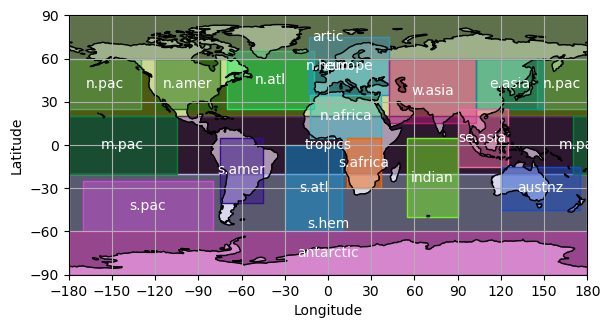

In [3]:
# Create the figure and axis
fig_width_mm = 170  # specify the width in millimeters
fig_height_mm = 120  # specify the height in millimeters
# Convert millimeters to inches (1 inch = 25.4 mm)
fig_width_inches = fig_width_mm / 25.4
fig_height_inches = fig_height_mm / 25.4


fig = plt.figure(figsize=(fig_width_inches, fig_height_inches))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=0))   
ax.set_global()
ax.coastlines(color='k')
ax.add_feature(cfeature.LAND, color='white')
ax.add_feature(cfeature.OCEAN, color='black')

# Set the aspect of the plot to equal
ax.set_aspect('equal')

# Draw the boxes for each region
for region, bounds in regions_with_bounds.items():
    lat = bounds['latitude']
    lon = bounds['longitude']
    
    # Generate a random RGBA color with a random alpha (transparency) value
    fill_color = np.random.rand(4)  # (R, G, B, Alpha)
    fill_color[3] = 0.5
    
    edge_color = fill_color.copy()
    edge_color[3] = 1
    
    # Normalize the longitude bounds to the range [-180, 180]
    lon = [((l + 180) % 360) - 180 for l in lon]
    
    # If the region crosses the antimeridian, split it into two boxes
    if lon[0] > lon[1]:
        lon_ranges = [(-180, lon[1]), (lon[0], 180)]
    else:
        lon_ranges = [(lon[0], lon[1])]
    
    for lon_range in lon_ranges:
        rect = plt.Rectangle((lon_range[0], lat[0]), lon_range[1] - lon_range[0], lat[1] - lat[0], edgecolor=edge_color, facecolor=fill_color)
        ax.add_patch(rect)
        plt.text((lon_range[0] + lon_range[1]) / 2, (lat[0] + lat[1]) / 2, region, ha='center', va='center', color='white')

# Set the latitude and longitude labels
ax.set_xticks(np.arange(-180, 181, 30))
ax.set_yticks(np.arange(-90, 91, 30))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Set the grid
ax.grid(True)

# Set the limits
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)

# filename = "/home/sc3020/OneDrive/Paper/Paper4/Nature/submittion2/Figures/regions0.png"
# plt.savefig(filename, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [3]:
filename = "/DATA/EAC4/eac4_lon_lat.npz"
npz_file = np.load(filename)
lon_mesh = npz_file['lon']-180
lat_mesh = npz_file['lat']

# Initialize an empty dictionary to store masks for each region
region_masks = {}

# Loop through the regions
for region, bounds in regions_with_bounds.items():
    lat = bounds['latitude']
    lon = bounds['longitude']
    
    # Normalize the longitude bounds to the range [-180, 180]
    lon = [((l + 180) % 360) - 180 for l in lon]
    
    # If the region crosses the antimeridian, split it into two boxes
    if lon[0] > lon[1]:
        lon_ranges = [(-180, lon[1]), (lon[0], 180)]
    else:
        lon_ranges = [(lon[0], lon[1])]
    
    # Create an empty mask for the region
    region_mask = np.zeros(lat_mesh.shape, dtype=bool)
    
    for lon_range in lon_ranges:
        lon_mask = np.logical_and(lon_mesh >= lon_range[0], lon_mesh <= lon_range[1])
        lat_mask = np.logical_and(lat_mesh >= lat[0], lat_mesh <= lat[1])
        part_region_mask = np.logical_and(lat_mask, lon_mask)
        region_mask = np.logical_or(region_mask, part_region_mask)

    # Store the region mask in the dictionary
    region_masks[region] = region_mask

In [7]:
from datetime import datetime, timedelta
from forecasting_metrics import evaluate

# regional analysis
inpath_refer = "/HDD/global/refer/refer-{}.npy"
# inpath_pred = "/DATA/global_opf/oper_moyd08_sparse/start_{}/oper-{}.npy"
# inpath_pred = "/DATA/global_opf/oper_11-17_moyd08_sparse_2018_3days_mask/start_{}/oper-{}.npy"
inpath_pred = "/DATA/global_opf/oper_11-17_moyd08_iAOD/start_{}/oper-{}.npy"
inpath_pred_cams = "/DATA/CAMS/cams_opf/cams-{}.npy"

# all times
start_date = datetime(2019, 1, 1, 0, 0)
end_date = datetime(2019, 12, 30, 23, 0)
inpath_pred = inpath_pred.format(start_date.strftime("%Y%m%d%H"), {})

# generate a list of datetime

interval = timedelta(hours=3)
date_list = []
current_date = start_date
while current_date <= end_date:
    date_list.append(current_date)
    current_date += interval

index = 0
nt = len(date_list)

# Initialize an empty dictionary to store metrics
metrics_region_ddnet = {}
metrics_region_cams = {}

# loop over for all regions
for region, mask in region_masks.items():
    # CAMS  
    RMSE_cams = []; R_cams = []
    # D-DNet
    RMSE_ddnet = []; R_ddnet = []
    
    # loop over all datetime
    for i in range(nt):    
        it = date_list[i]
        
        filename = inpath_refer.format(it.strftime('%Y%m%d%H'))
        referY = np.load(filename)[...,index][mask]
        
        filename = inpath_pred.format(it.strftime('%Y%m%d%H'))
        ddnetY = np.load(filename)[...,index][mask]
        
        filename = inpath_pred_cams.format(it.strftime('%Y%m%d%H'))
        camsY = np.load(filename)[...,index][mask]

        metrics = evaluate(referY, ddnetY, metrics=('rmse', 'cc'))
        RMSE_ddnet.append(metrics['rmse'])
        R_ddnet.append(metrics['cc']**2)

        metrics = evaluate(referY, camsY, metrics=('rmse', 'cc'))
        RMSE_cams.append(metrics['rmse'])
        R_cams.append(metrics['cc']**2)
    
    metrics_region_ddnet[region] = {'rmse': RMSE_ddnet, 'r': R_ddnet}
    metrics_region_cams[region] = {'rmse': RMSE_cams, 'r': R_cams}

/home/sc3020/OneDrive/Paper/Paper4/Nature/submittion2/Figures2_iAOD/Reg_Ana_pm2p5_rmse.png


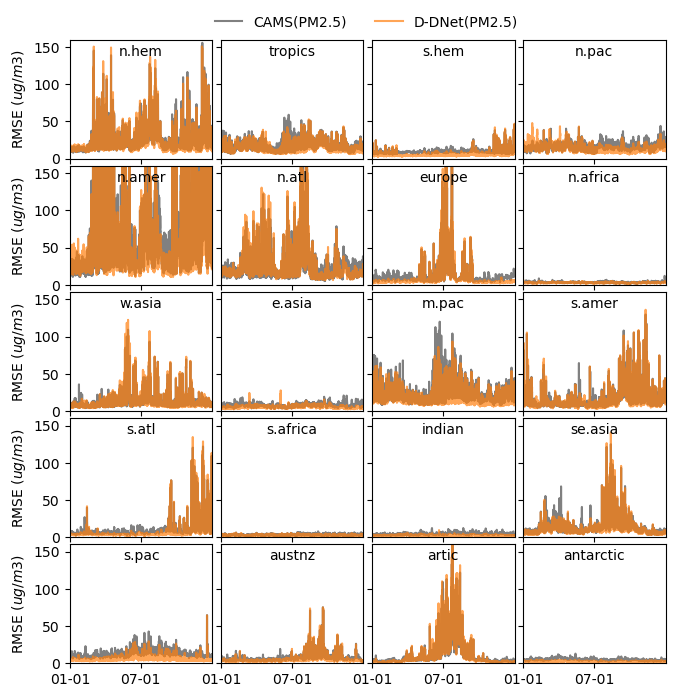

In [9]:
# times_plot
from matplotlib.dates import DateFormatter, DayLocator, MonthLocator

draw_matric = 'rmse'
features = ['pm2p5', 'aod550']
scale = {'rmse':[1e9, 1], 'r': [1.1,1.1]}
maxs = {'rmse':[160, 0.21], 'r': [1.1,1.1]}
titles = ['PM2.5', 'AOD550']
ylabels = {'rmse':['RMSE ($ug/m3$)', 'RMSE'], 'r': ['R2', 'R2']}
labels = ['CAMS({})', 'D-DNet({})']
colors = ['grey', 'C1']

date_plot = [datetime.fromisoformat(str(date)) for date in date_list]
ititle = titles[index]

figure_width_mm = 170
figure_height_mm = 180
figure_width_inches = figure_width_mm / 25.4
figure_height_inches = figure_height_mm / 25.4

fig, ax = plt.subplots(5, 4, figsize=(figure_width_inches, figure_height_inches), sharex=True, sharey=True)
ax = ax.flatten()

i = 0
for region in region_masks:
    metrics_ddnet = metrics_region_ddnet[region]
    metrics_cams = metrics_region_cams[region]
    ax[i].plot(date_plot, scale[draw_matric][index]*np.array(metrics_cams[draw_matric]), label = labels[0].format(titles[index]), color=colors[0])
    ax[i].plot(date_plot, scale[draw_matric][index]*np.array(metrics_ddnet[draw_matric]), label = labels[1].format(titles[index]), color=colors[1], alpha=0.7)
    ax[i].text(date_plot[int(nt/2)],0.9*maxs[draw_matric][index], region, ha='center', va='center')
    ax[i].set_ylim(0,maxs[draw_matric][index])
    if i % 4 == 0:
        ax[i].set_ylabel(ylabels[draw_matric][index])
        # ax[i].set_ylabel('R')
    
    i = i + 1
    
plt.subplots_adjust(wspace=0.06, hspace=0.06, left=0.09, right=0.98, top=0.95, bottom=0.07)

ax[1].set_xlim(date_plot[0], date_plot[-1])
ax[1].xaxis.set_major_locator(MonthLocator(interval=6))  # Set the tick interval
ax[1].xaxis.set_major_formatter(DateFormatter("%m-%d"))  # Format the tick labels
plt.legend(loc='upper center', frameon=False, bbox_to_anchor=(-1.1, 5.55), ncol=2)

filename = path_fig + 'Reg_Ana_{}_{}.png'.format(features[index], draw_matric)
print(filename)
fig.savefig(filename, dpi=300)

plt.show()

In [10]:
# make a percentage comparison

def percent_count(R, r2_list, mode):
    
    r2_array = np.array(R)
    total = r2_array.size
    
    # r2_list = np.arange(0, 1.01, 0.01)
    percent_r2_list = []
    for r2_min in r2_list:
        r2_min_count = r2_array >= r2_min
        percent = r2_min_count.sum()/total
        percent_r2_list.append(percent)
    
    if mode == 'rmse':
        percent_r2_list = 1-np.array(percent_r2_list)
    else:
        percent_r2_list = np.array(percent_r2_list)
        
    return percent_r2_list

82.61700969148897
33.05634961730136
26.081300548063233
25.345532325184614
316.43791546520777
147.16612739838027
114.8593507923348
6.91223753220557
57.10186623926892
11.907289546295848
64.46818325976754
67.3407363005447
62.8703917480764
4.678642324523203
7.058160901167334
64.55029331200457
35.413397808490046
39.25490963804856
85.05764519356633
7.524572589603279
/home/sc3020/OneDrive/Paper/Paper4/Nature/submittion2/Figures2_iAOD/Percent_Reg_Ana_pm2p5_rmse.png


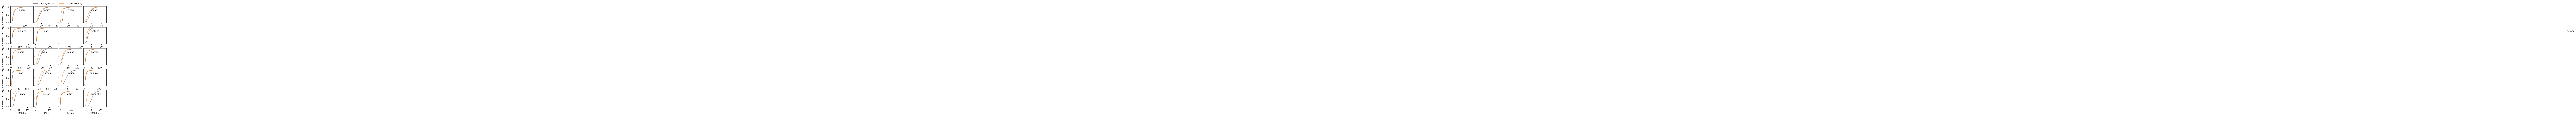

In [22]:
# times_plot
from matplotlib.dates import DateFormatter, DayLocator, MonthLocator

draw_matric = 'rmse'
features = ['pm2p5', 'aod550']
scale = {'rmse':[1e9, 1], 'r': [1.1,1.1]}
maxs = {'rmse':[150, 0.21], 'r': [1.1,1.1]}
titles = ['PM2.5', 'AOD550']
ylabels = {'rmse':['RMSE', 'RMSE'], 'r': ['R2', 'R2']}
labels = ['CAMS({})', 'D-DNet({})']
colors = ['grey', 'C1']

date_plot = [datetime.fromisoformat(str(date)) for date in date_list]
ititle = titles[index]

figure_width_mm = 170
figure_height_mm = 180
figure_width_inches = figure_width_mm / 25.4
figure_height_inches = figure_height_mm / 25.4

fig, ax = plt.subplots(5, 4, figsize=(figure_width_inches, figure_height_inches), sharex=False, sharey=True)
ax = ax.flatten()

i = 0
for region in region_masks:
    
    metrics_cams = scale[draw_matric][index]*np.array(metrics_region_cams[region][draw_matric])
    # percentage
    metrics_list =  np.linspace(np.min(metrics_cams), np.max(metrics_cams), 100)
    percent_cams = percent_count(metrics_cams, metrics_list, mode=draw_matric) 
    ax[i].plot(metrics_list, percent_cams, label = labels[0].format(titles[index]), color=colors[0])
    print(metrics_list[int(100/2)])
    ax[i].text((np.min(metrics_cams)+np.max(metrics_cams))/2,0.8, region, ha='center', va='center')
    
    metrics_ddnet = scale[draw_matric][index]*np.array(metrics_region_ddnet[region][draw_matric])
    metrics_list =  np.linspace(np.min(metrics_ddnet), np.max(metrics_ddnet), 100)
    percent_ddnet = percent_count(metrics_ddnet, metrics_list, mode=draw_matric) 
    ax[i].plot(metrics_list, percent_ddnet, label = labels[1].format(titles[index]), color=colors[1], alpha=0.7)
    
    # ax[i].set_ylim(0,maxs[draw_matric][index])
    if i % 4 == 0:
        ax[i].set_ylabel('P({} < {}$_0$)'.format(ylabels[draw_matric][index], ylabels[draw_matric][index]))

    
    if i >= 16:
        ax[i].set_xlabel(ylabels[draw_matric][index]+'$_0$')
    
    # ax[i].grid()
    ax[6].set_xlim(0.01, 1.05)
    i = i + 1

ax[1].legend(loc='upper center', bbox_to_anchor=(1.0, 1.35), ncol=2, frameon=False) 
plt.subplots_adjust(wspace=0.06, hspace=0.25, left=0.09, right=0.98, top=0.95, bottom=0.07)

filename = path_fig + 'Percent_Reg_Ana_{}_{}.png'.format(features[index], draw_matric)
print(filename)
fig.savefig(filename, dpi=300)

plt.show()

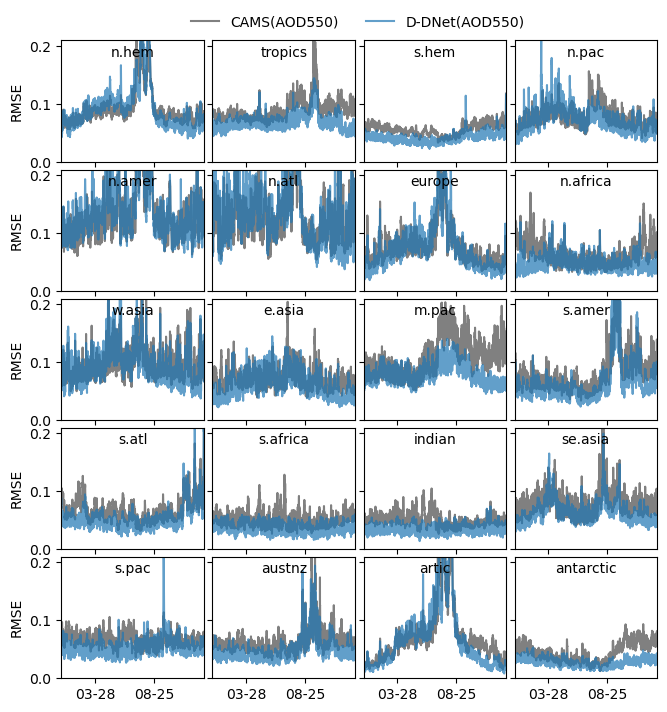

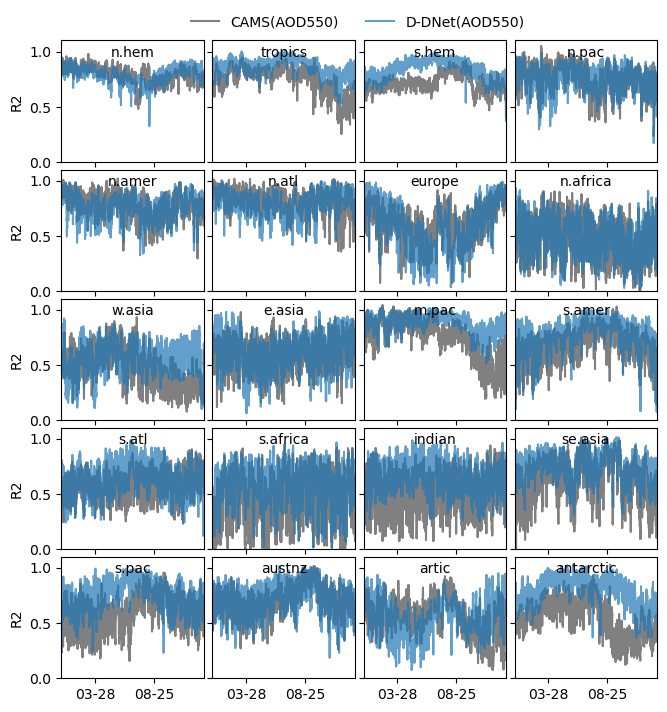

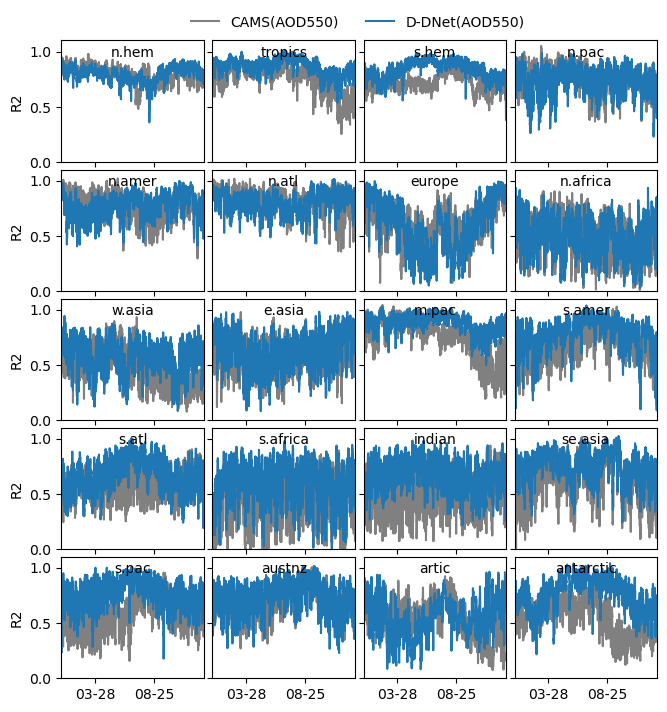

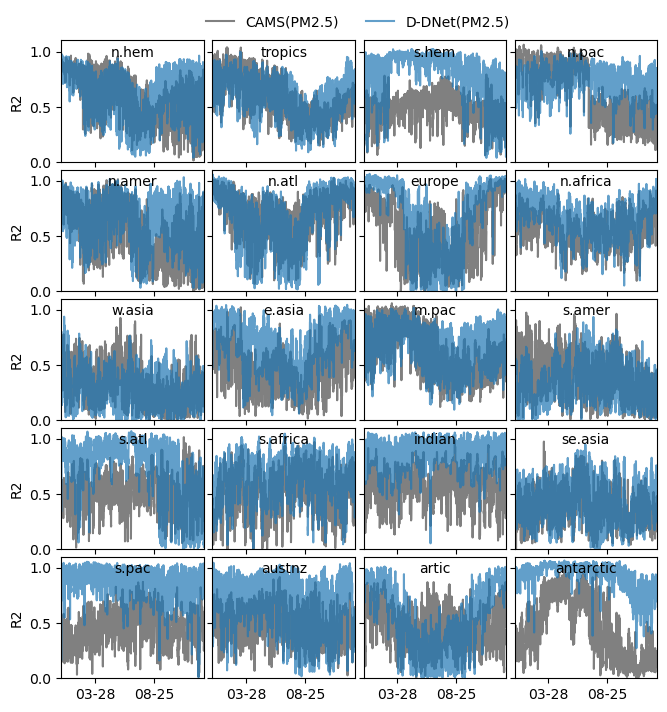

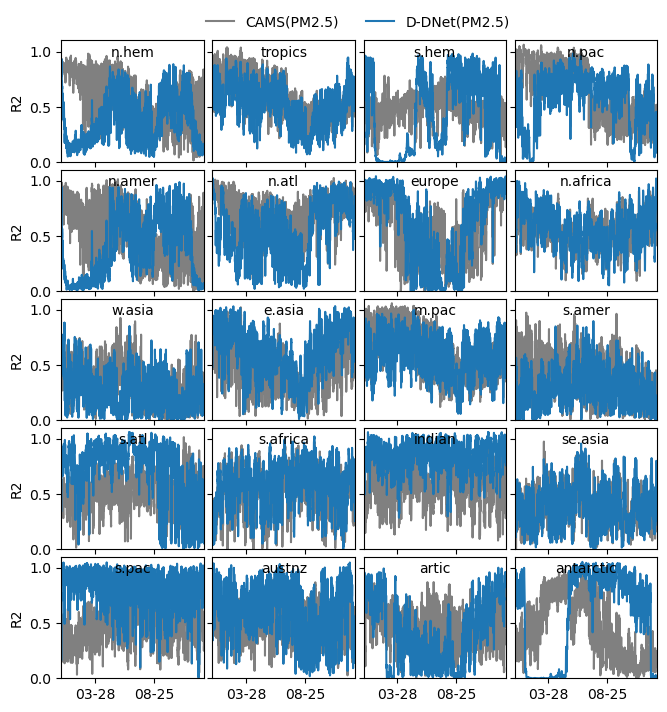

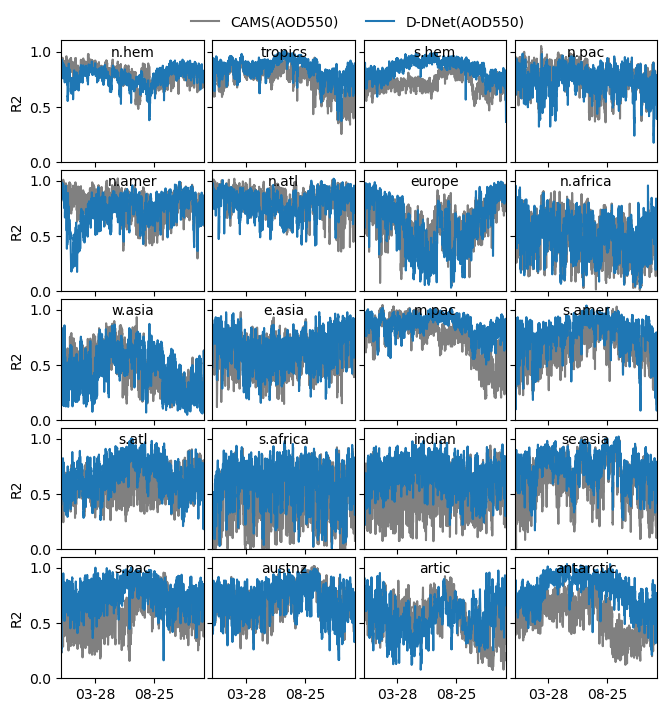

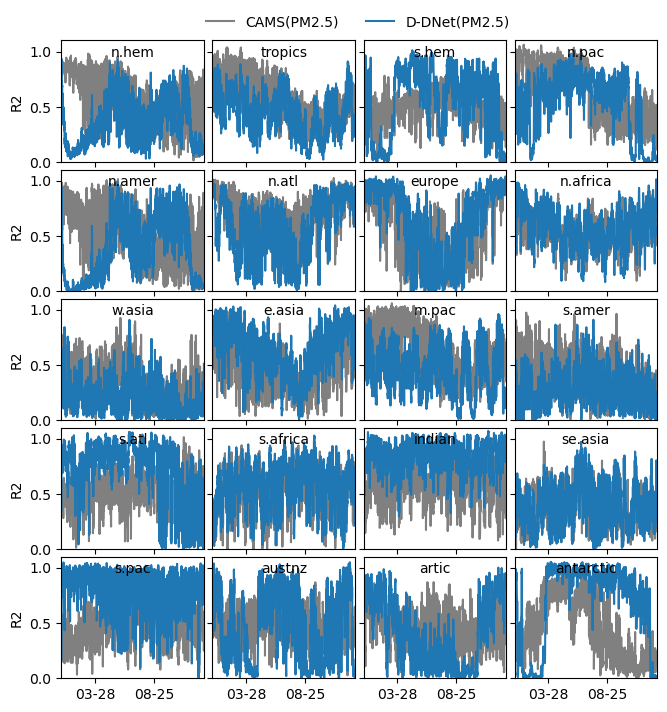

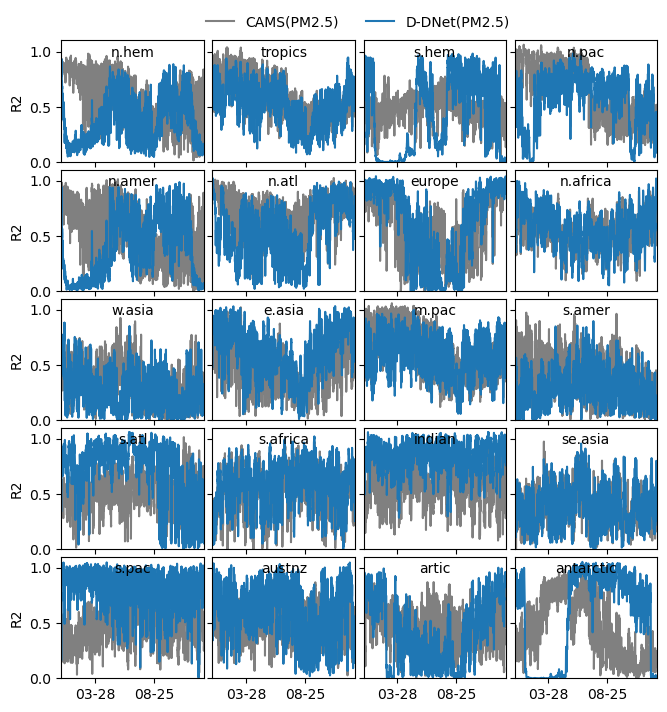

/home/sc3020/OneDrive/Paper/Paper4/Nature/submittion2/Figures/Reg_Ana_pm2p5_r.png


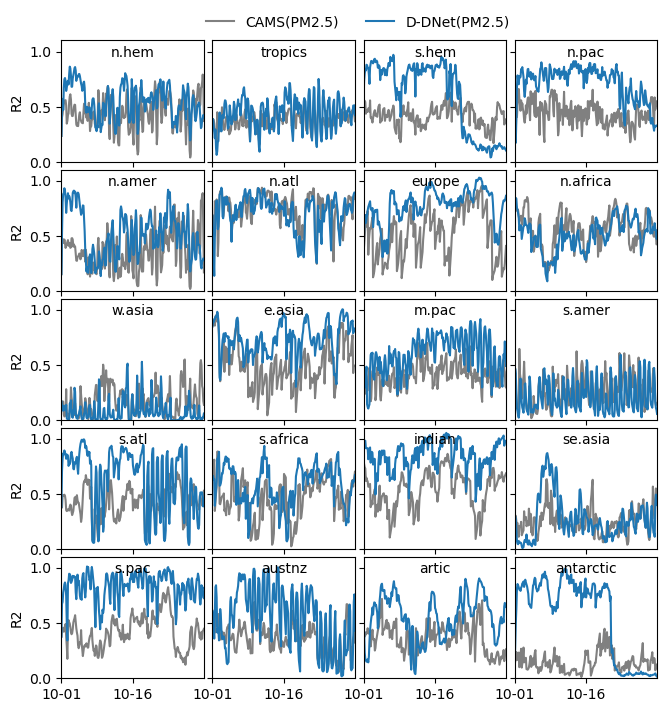